In [1]:
import warnings

warnings.filterwarnings('ignore')

In [130]:
import pandas as pd
import numpy as np
np.random.seed(3104)

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import matplotlib as mlp

mlp.rcParams['lines.linewidth'] = 5

mlp.rcParams['xtick.major.size'] = 15
mlp.rcParams['xtick.major.width'] = 2
mlp.rcParams['xtick.labelsize'] = 15
mlp.rcParams['xtick.color'] = '#4DFC2D'

mlp.rcParams['ytick.major.size'] = 15
mlp.rcParams['ytick.major.width'] = 2
mlp.rcParams['ytick.labelsize'] = 15
mlp.rcParams['ytick.color'] = '#4DFC2D'

mlp.rcParams['axes.labelsize'] = 20
mlp.rcParams['axes.titlesize'] = 20
mlp.rcParams['axes.titlecolor'] = '#ED6919'
mlp.rcParams['axes.labelcolor'] = '#ED6919'

In [131]:
ratings = pd.read_csv('ratings.csv', sep=',').head(1000000)

ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [132]:
tags = pd.read_csv('tags.csv').drop('timestamp', axis=1)

tags.head()

,userId,movieId,tag
0,18,4141,Mark Waters
1,65,208,dark hero
2,65,353,dark hero
3,65,521,noir thriller
4,65,592,dark hero


In [133]:
movies = pd.read_csv('movies.csv')

movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## Project overview
1. [EDA](#eda)

    - [Ratings](#ratings)
    - [Tags](#tags)
    - [Movies](#movies)
 

<a id='eda'></a>
### Exploratory data analysis

<a id='ratings'></a>

#### Ratings

In [134]:
ratings.timestamp = pd.to_datetime(ratings.timestamp, unit='s')

In [135]:
ratings.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

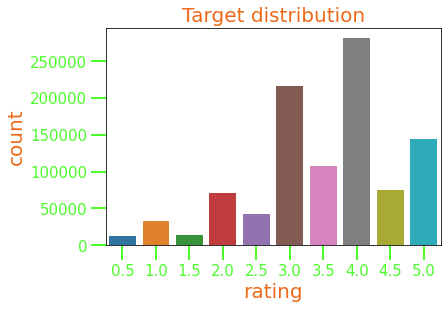

In [136]:
sns.countplot(ratings.rating)

plt.title('Target distribution')
plt.show()

In [137]:
ratings['year'] = ratings.timestamp.dt.year
ratings['hour'] = ratings.timestamp.dt.hour
ratings = ratings.sort_values(by='timestamp')

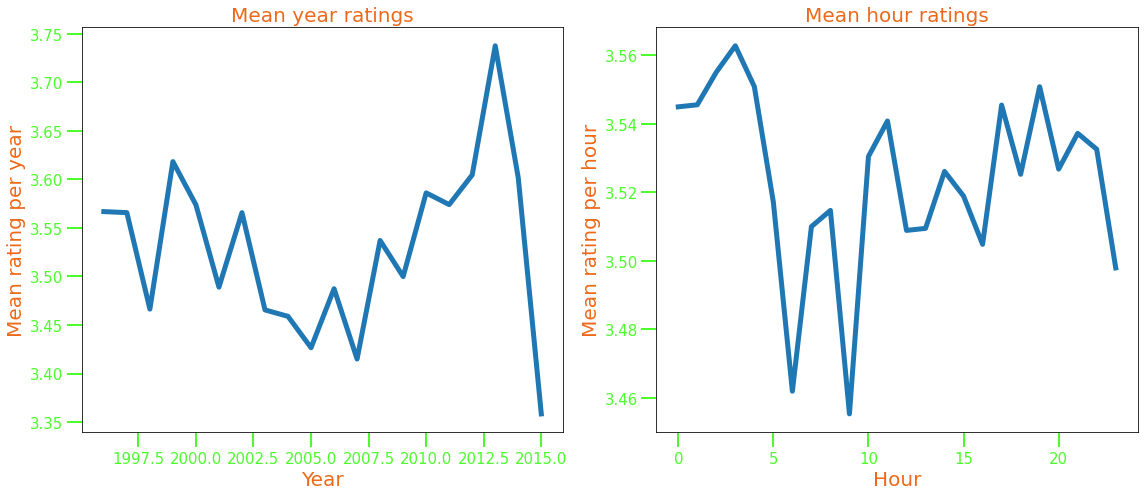

In [138]:
fig = plt.figure(figsize=(16, 7))

ax1 = fig.add_subplot(1, 2, 1)
grouped = ratings.groupby('year').rating.mean().reset_index()
plt.plot(grouped.year, grouped.rating)
plt.xlabel('Year')
plt.ylabel('Mean rating per year')
plt.title('Mean year ratings')

ax2 = fig.add_subplot(1, 2, 2)
grouped = ratings.groupby('hour').rating.mean().reset_index()
plt.plot(grouped.hour, grouped.rating)

plt.xlabel('Hour')
plt.ylabel('Mean rating per hour')
plt.title('Mean hour ratings')

plt.tight_layout()
plt.show()

<a id='tags'></a>

#### Tags

In [139]:
tags.tag.nunique()

38643

In [140]:
tags['tag_count'] = tags.tag.map(
    tags.tag.value_counts()
)

tags.head()

,userId,movieId,tag,tag_count
0,18,4141,Mark Waters,10.0
1,65,208,dark hero,194.0
2,65,353,dark hero,194.0
3,65,521,noir thriller,327.0
4,65,592,dark hero,194.0


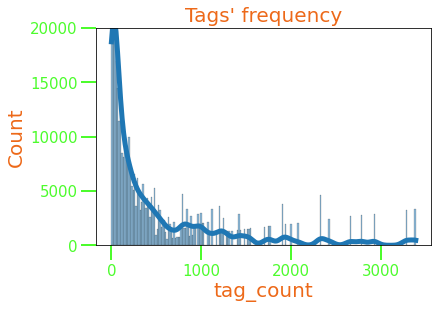

In [141]:
sns.histplot(tags.tag_count, kde=True)

plt.title("Tags' frequency")
plt.ylim(0, 20000)
plt.show()

In [142]:
tags.isna().sum()

userId        0
movieId       0
tag          16
tag_count    16
dtype: int64

In [143]:
missing = tags[tags.tag.isna()]

missing.userId.nunique()

2

In [144]:
tags = tags.dropna()

tags.isna().sum()

userId       0
movieId      0
tag          0
tag_count    0
dtype: int64

In [145]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Perform TF-IDF and ignore numbers / common English words / 1-letter words
tf = TfidfVectorizer(token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b', stop_words='english')

df = pd.DataFrame(tf.fit_transform(tags.tag).todense())
df.columns = tf.get_feature_names()

df.sample(5)

,1000th,10s,12th,13th,14th,1500s,15th,1600s,16mm,16th,...,øje,øjne,øjnene,økonomisk,østergaard,øvredal,øvrigt,última,übergang,þór
418860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
118913,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
156025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103448,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
318382,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
tags['tag_tf_idf_mean'] = df.mean(axis=1)

In [ ]:
sns.histplot(tags.tag_tf_idf_mean)

plt.title('TF-IDF score distribution')
plt.ylim(0, 7)
plt.show()

<a id='movies'></a>

#### Movies

In [ ]:
movies.head()

In [92]:
import re

def title_feature_extraction(title):
    m = re.search(r"\(([0-9_]+)\)", title)
    return None if m is None else m.group(1)

In [93]:
movies['movie_year'] = movies.title \
                        .apply(title_feature_extraction) \
                        .apply(lambda x: None if x is None or int(x) < 1888 else int(x))

movies.isna().sum()

movieId        0
title          0
genres         0
movie_year    25
dtype: int64

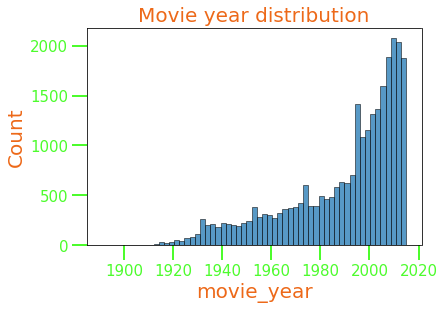

In [94]:
sns.histplot(movies.movie_year)

plt.title('Movie year distribution')
plt.show()

In [95]:
movies.movie_year = movies.movie_year.fillna(
    movies.movie_year.value_counts().index[0]
)

In [96]:
genres = movies.genres.str.get_dummies(sep='|')

genres.head()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [97]:
movies = pd.concat(
    (movies, genres),
    axis=1
)

In [98]:
movies.isna().sum().sum()

0

In [101]:
movies.title = movies.title.apply(
    lambda x:
        x.split('(')[0] if x.contains('(') else 'NaN_title'
)

movies.head()

,movieId,title,genres,movie_year,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji,Adventure|Children|Fantasy,1995.0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men,Comedy|Romance,1995.0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995.0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II,Comedy,1995.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [102]:
tf = TfidfVectorizer(token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b', stop_words='english')

df = pd.DataFrame(tf.fit_transform(movies.title).todense())
df.columns = tf.get_feature_names()

df.sample(5)

,10th,110th,11th,12th,13b,13hrs,13th,14th,19th,1st,...,école,époque,équipe,état,étoile,étudiante,öga,último,üvegtigris,貞子3d
11985,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22908,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12053,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [104]:
movies['movie_tf_idf_mean'] = df.mean(axis=1)

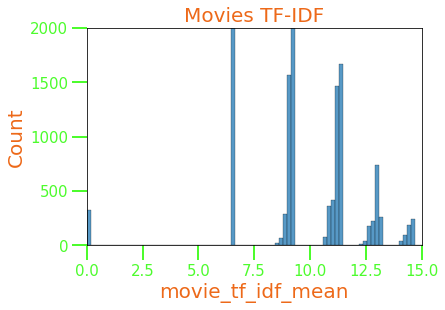

In [114]:
sns.histplot(movies.movie_tf_idf_mean * 1e5)

plt.xlim(0, 15)
plt.ylim(0, 2000)
plt.title('Movies TF-IDF')
plt.show()

In [88]:
movies = movies.drop(['title', 'genres'], axis=1)

movies.head()

,movieId,movie_year,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1995.0,0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1995.0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1995.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,1995.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,1995.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
